# SuPreMo walkthrough

In this walkthrough, we will run get_seq on CTCF binding site deletions, which we generated in [custom_perturbations.ipynb](https://github.com/ketringjoni/Akita_variant_scoring/blob/main/walkthroughs/custom_perturbations.ipynb).

To do so, we've run the following command (the output of the following cell) in the terminal. By changing the variables below, you can get a command that fits your custom set of perturbations. Note: there are more arguments available that are not included here.  

In [1]:
import pandas as pd
import numpy as np
import os
import pysam
from collections import Counter

In [2]:
# Change the following paths to match your working directory/input file/output files

data_dir = 'test_data/custom_perturbations/'

in_file = f'{data_dir}input/CTCF_del_symb_alleles.txt' # Input directory
directory = f'{data_dir}output' # Output directory

In [3]:
# Write command

shift_by = '-1 0 1' # Shift sequences by 1 bp left and right
revcomp = 'add_revcomp' # Also score the reverse complement of all sequences
file = 'CTCF_del' # Output files prefix
seq_length = 1000 # This is the sequence length required for DeepSEA


out_file = os.path.join(directory, file) # Path to output files

print('Run this command in the main directory:\n')
print('python scripts/SuPreMo.py', in_file,
      '--shift_by', shift_by,
      '--revcomp', revcomp,
      '--file', file,
      '--dir', directory,
      '--get_seq',
      '--seq_len', seq_length)


Run this command in the main directory:

python scripts/SuPreMo.py test_data/custom_perturbations/input/CTCF_del_symb_alleles.txt --shift_by -1 0 1 --revcomp add_revcomp --file CTCF_del --dir test_data/custom_perturbations/output --get_seq --seq_len 1000


In [4]:
# Read input

import sys
sys.path.insert(0, '../scripts')

import reading_utils
reading_utils.var_set_size = 10000000000

variants = reading_utils.read_input(f'../{in_file}', 0)
variants[:10]

,CHROM,POS,REF,ALT,END,SVTYPE,SVLEN
0,chr1,100276250,-,-,100276269,DEL,19
1,chr1,101106697,-,-,101106716,DEL,19
2,chr1,101159421,-,-,101159440,DEL,19
3,chr1,101442377,-,-,101442396,DEL,19
4,chr1,101526743,-,-,101526762,DEL,19
5,chr1,101595702,-,-,101595721,DEL,19
6,chr1,101693506,-,-,101693525,DEL,19
7,chr1,101744879,-,-,101744898,DEL,19
8,chr1,102007853,-,-,102007872,DEL,19
9,chr1,10192988,-,-,10193007,DEL,19


# Filtered out file

In [9]:
# Read filtered out file

filtered_out_file = f'../{out_file}_filtered_out'

if os.path.getsize(filtered_out_file) == 0:
    
    print('No perturbations were filtered out.')

else:
    
    with open(filtered_out_file) as f:
        filtered_out = f.read().splitlines()
        
    # Get the number of variants that were filtered out for each type of reason

    print(Counter([x.split(': ')[1] for x in filtered_out]))
    
    
    # Get list of perturbations (input row number) that were filtered out

    filtered_out_rows = np.unique([int(x.split(': ')[0]) for x in filtered_out])

    print(filtered_out_rows[:10])

No perturbations were filtered out.


# Log file

Check the log file for errors and warnings

In [10]:
# Read log file

with open(f'../{out_file}_log') as f: # 
    log = f.read().splitlines()

log[:10]

['0 (-1 shift)',
 '0 (0 shift)',
 '0 (0 shift_revcomp)',
 '0 (1 shift)',
 '1 (-1 shift)',
 '1 (0 shift)',
 '1 (0 shift_revcomp)',
 '1 (1 shift)',
 '2 (-1 shift)',
 '2 (0 shift)']

In [30]:
print('There are',len(log),'log messages so the counts below are out of', len(log))

There are 200 log messages so the counts below are out of 200


## Warnings

In [31]:
# Get perturbations that had warnings

warnings = [x for x in log if 'Warning' in x]

warnings[:10]

[]

In [32]:
# Get the number of each type of warning message

Counter([x.split('Warning: ')[1] for x in warnings])

Counter()

In [33]:
# Get list of perturbations (input row number) that have warnings in at least one of the conditions

warning_rows = np.unique([x.split(' (')[0] for x in warnings])

warning_rows[:10]

array([], dtype=float64)

## Errors 

In [34]:
# Get perturbations that had errors

errors = [x for x in log if 'Error' in x]
error_messages = [x.split('Error: ')[1] for x in errors]

errors[:10]

[]

In [35]:
# These are all the expected error messages

with open('../scripts/get_seq_utils.py', 'r') as f:
    get_seq_error_messages = np.unique([l.split('\'')[1] for l in f if 'raise ValueError' in l])

print('get_seq expected error messages:\n\n', get_seq_error_messages, '\n\n')


get_seq expected error messages:

 ['Alternate sequence generated is not the right length.'
 'Cannot generate 1Mb sequence for this chromosomal rearrangement.'
 'Centromeric variant.' 'N composition greater than 5%.'
 'Reference allele does not match hg38.'
 'Reference sequence generated is not the right length.'
 'SV type not supported.'
 'Sequence for the alternate allele does not match hg38 at REF position.'
 'Unexpected format: BND ALT does not include REF.'
 'Variant larger than set limit.'] 




In [36]:
# Get the number of each type of expected error message

Counter(error_messages)

Counter()

In [37]:
# Get number of get_seq and get_Akita_scores error messages

print(len([x for x in error_messages if x in get_seq_error_messages]), 'get_seq error messages')
print(len([x for x in error_messages if x in get_Akita_scores_error_messages]), 'get_Akita_scores error messages')

0 get_seq error messages
0 get_Akita_scores error messages


In [38]:
# Check if any of these errors are unexpected

[x for x in error_messages if x not in get_seq_error_messages and x not in get_Akita_scores_error_messages]

[]

In [39]:
# Get list of perturbations (input row number) that have errors in at least one of the conditions

error_rows = np.unique([x.split(' (')[0] for x in errors])

error_rows[:10]

array([], dtype=float64)

# Read in sequences

In [5]:
seq_file = f'../{out_file}' + '_sequences.fa'

seq_names = pysam.Fastafile(seq_file).references
seq_names[:10]

['0_-1_0_[490_500]',
 '0_-1_1_[490_500]',
 '0_0_0_[489_499]',
 '0_0_1_[489_499]',
 '0_0_revcomp_0_[489_499]',
 '0_0_revcomp_1_[489_499]',
 '0_1_0_[488_498]',
 '0_1_1_[488_498]',
 '1_-1_0_[490_500]',
 '1_-1_1_[490_500]']

In [10]:
f'{var_index}_{shift}{revcomp_annot}'

'0_0'

In [32]:
'sequence_names' 

True

In [25]:
var_index = 0
shift = 0
revcomp_annot = ''

if revcomp_annot == '':
    sequence_names = [x for x in seq_names if x.startswith(f'{var_index}_{shift}') and 'revcomp' not in x]
elif revcomp_annot == 'revcomp':
    sequence_names = [x for x in seq_names if x.startswith(f'{var_index}_{shift}_{revcomp_annot}')]
    
sequences_i = []
for sequence_name in sequence_names:
    sequences_i.append(pysam.Fastafile(seq_file).fetch(sequence_name, 0, seq_length).upper())

sequences_i.append([int(x) for x in sequence_name.split('[')[1].split(']')[0].split('_')])
    
    

In [26]:
sequences_i

['CCTAAAATAGTTATCTAATTAAATTAAAGATTTTTAGGGTTTCTTGCTTAAGTTTATAGTTTTAAGAAGTATTTATTTATTTATTTATTTATTGAGGTGGAGTCTCGCTCTGTTGTCCAGGCTGGAGTGCCGTGGTGTGATCTTGGCTCACTGCAAGCTCCGCCTCCTGGGTTCATGCCATTCTTCTGCCTGAGCCTCCTGAGTAGCTGGGACTACAGGCGCCCACCACCACGCCCAGCTAATTTTTTGTATTTTTAGTAGAGACAGGGTTTCACCGTGTTAGCCAGGGTGGTCTTGATCTCCTGACCTCATGATCCACCTGCCTTGGCCTCCCAAAGTGCTGGGATTACAGGCATGAGCCACTGTGCCCAGCCTCAGTTTATATTTTTAAGGACATTCCTACCTAAAACACCAGTATGATAAATTAAGACAATTATTCTGAATTTTTTCTGAGGATGGCTTGCCTTTTGTTACCTTGTAAGATCCCTTTCCCTTATATAGTGAACTTAAACGTTTAATCAGAAGTTAGGCTTTAAAGCTAGTCCTATGAGAATATTTCCAGTTGCATAAAATACGTCAAATGTGAAATCAGTTCACAAATAAATATAGCAAAGAGCTTTTTAAAACCAGACTAGAGGCCAGGCGCGGTGGCTTACACCTGTAATCCCAGCACTTTGGGAGGCTGAGGCGGGCAGATCACAAGGTCAAGAGATCAAGATCATCCTGGCCAACATGGTGAAACCCTGTCTCTACTAAAAATACAAAAATTAGCTGGGCGTGGTGGTGCACACCTGTAGTCCCAGCTACTTGGGAGGCTGAGGCAGGAGAATCACTTGAACCTGGGAGGCGGATGTTGCAGTGAGCTGAGATCACACCACTGCACTCCAGCCTGGCGACAAAGCGAGACTCCATCTCAAAAAAAACCAGACTAGAACTATTATGTTAATTCAGTTAGGAGTTATAGATTTAAGTATTAGTACAAATTCTTTAACTGATGT

In [6]:
pysam.Fastafile(seq_file).fetch(seq_names[0], 0, seq_length).upper()

'CCCTAAAATAGTTATCTAATTAAATTAAAGATTTTTAGGGTTTCTTGCTTAAGTTTATAGTTTTAAGAAGTATTTATTTATTTATTTATTTATTGAGGTGGAGTCTCGCTCTGTTGTCCAGGCTGGAGTGCCGTGGTGTGATCTTGGCTCACTGCAAGCTCCGCCTCCTGGGTTCATGCCATTCTTCTGCCTGAGCCTCCTGAGTAGCTGGGACTACAGGCGCCCACCACCACGCCCAGCTAATTTTTTGTATTTTTAGTAGAGACAGGGTTTCACCGTGTTAGCCAGGGTGGTCTTGATCTCCTGACCTCATGATCCACCTGCCTTGGCCTCCCAAAGTGCTGGGATTACAGGCATGAGCCACTGTGCCCAGCCTCAGTTTATATTTTTAAGGACATTCCTACCTAAAACACCAGTATGATAAATTAAGACAATTATTCTGAATTTTTTCTGAGGATGGCTTGCCTTTTGTTACCTTGTAAGATCCCTTTCCCTTATATAGTGAACTTAAACGTTTAATCAGAAGTTAGGCTTTAAAGCTAGTCCTATGAGAATATTTCCAGTTGCATAAAATACGTCAAATGTGAAATCAGTTCACAAATAAATATAGCAAAGAGCTTTTTAAAACCAGACTAGAGGCCAGGCGCGGTGGCTTACACCTGTAATCCCAGCACTTTGGGAGGCTGAGGCGGGCAGATCACAAGGTCAAGAGATCAAGATCATCCTGGCCAACATGGTGAAACCCTGTCTCTACTAAAAATACAAAAATTAGCTGGGCGTGGTGGTGCACACCTGTAGTCCCAGCTACTTGGGAGGCTGAGGCAGGAGAATCACTTGAACCTGGGAGGCGGATGTTGCAGTGAGCTGAGATCACACCACTGCACTCCAGCCTGGCGACAAAGCGAGACTCCATCTCAAAAAAAACCAGACTAGAACTATTATGTTAATTCAGTTAGGAGTTATAGATTTAAGTATTAGTACAAATTCTTTAACTGATGT

In [ ]:
input_sequences[x for x in input_sequences. if f'{var_index}_{shift}{revcomp_annot}_{ii}' in x]

In [44]:
# Get sequences

sequences = {}

shift_by = str(0)

for var_index in variants.index:
    for shift in shift_by.split(' '):
        for revcomp in ['']:

            if 'SVLEN' in variants.columns:
                
                SVTYPE = variants.iloc[var_index].SVTYPE
                SVLEN = variants.iloc[var_index].SVLEN
                if SVTYPE == 'DUP':
                    SVLEN = 2*SVLEN
            else:
                SVTYPE, SVLEN = '-', '0'


            if SVTYPE == 'BND':
                alleles = {0: 'REF1', 
                           1: 'REF2',
                           2: 'ALT'}
            else:
                alleles = {0: 'REF', 
                           1: 'ALT'}


            for allele in range(len(alleles)):
                variant_id = f'{var_index}_{shift}{revcomp}_{allele}'

                seq_name = [x for x in seq_names if variant_id in x][0]

                position = int(seq_name.split('[')[1].split(']')[0].split('_')[allele])

                sequence = pysam.Fastafile(seq_file).fetch(seq_name, 0, seq_length).upper()

                sequences.update({str(var_index)+'_'+alleles[allele]:sequence})

                # Look at the region where the variant is in that sequence
                print('var_index =',var_index, '\tshift =', shift, revcomp,
                      '\tstart of variant:', sequence[position:position+SVLEN][:10],
                      '\tend of variant:', sequence[position:position+SVLEN][-10:])

var_index = 0 	shift = 0  	start of variant: TCCCTTATAT 	end of variant: TAGTGAACTT
var_index = 0 	shift = 0  	start of variant: TAACGTTTAA 	end of variant: ATCAGAAGTT
var_index = 1 	shift = 0  	start of variant: AATTGATAAG 	end of variant: GCCACTGACT
var_index = 1 	shift = 0  	start of variant: AGACTGACCA 	end of variant: AAGAAAATAA
var_index = 2 	shift = 0  	start of variant: TGCATAGTGG 	end of variant: GTGCAATAAA
var_index = 2 	shift = 0  	start of variant: TATACGTGTG 	end of variant: GCATGTGTCT
var_index = 3 	shift = 0  	start of variant: TCTGCCCTCT 	end of variant: TTGGGTTTTT
var_index = 3 	shift = 0  	start of variant: TTGGAAGCTC 	end of variant: CCATGATGTC
var_index = 4 	shift = 0  	start of variant: GAGTTAGAGA 	end of variant: AAGTGGATGC
var_index = 4 	shift = 0  	start of variant: GCTTGTGTAG 	end of variant: GTAGATAAAT
var_index = 5 	shift = 0  	start of variant: GCATCTTCCA 	end of variant: ACCAATATAA
var_index = 5 	shift = 0  	start of variant: GGTTGTTTTG 	end of variant: GTC

## Run DeepSEA

In [14]:
path = '../DeepSEA/'

import sys
sys.path.insert(0, path)
from selene_sdk.utils import load_path
from selene_sdk.utils import parse_configs_and_run

In [51]:
configs = load_path(f'{path}get_predictions.yml')

In [1]:
# Adjust the path to the main SuPreMo directory in get_predictions.yml 

! cat ../DeepSEA/get_predictions.yml

---
ops: [analyze]
model: {
    path: {path_to_main_directory}DeepSEA/deeperdeepsea.py, 
    class: DeeperDeepSEA,
    class_args: {
        sequence_length: 1000,
        n_targets: 919
    },
#     non_strand_specific: mean
}
analyze_sequences: !obj:selene_sdk.predict.AnalyzeSequences {
    trained_model_path: {path_to_main_directory}DeepSEA/example_deeperdeepsea.pth.tar,
    sequence_length: 1000,
    features: !obj:selene_sdk.utils.load_features_list {
        input_path: {path_to_main_directory}Akita_variant_scoring/DeepSEA/distinct_features.txt 
    },
    batch_size: 64,
    use_cuda: False,
    reference_sequence: !obj:selene_sdk.sequences.Genome {
        input_path: {path_to_main_directory}data/hg38.fa,
        blacklist_regions: hg38
    },
    write_mem_limit: 75000
}
prediction: {
    input_path: {path_to_main_directory}test_data/custom_perturbations/output/CTCF_del_sequences.fa,
    output_dir: {path_to_main_directory}DeepSEA/output,
    output_format: tsv
}
random_seed: 

In [ ]:
# Run DeepSEA
parse_configs_and_run(configs)

## Read DeepSEA output

In [12]:
ls ../DeepSEA/output/

CTCF_del_sequences_predictions.tsv  score_var_results_sequences_predictions.tsv


In [15]:
path = '../DeepSEA/'
deepsea_scores = pd.read_csv(f'{path}output/CTCF_del_sequences_predictions.tsv', sep = '\t')
deepsea_scores[:10]

,index,name,8988T|DNase|None,A549|ATF3|EtOH_0.02pct,A549|BCL3|EtOH_0.02pct,A549|BHLHE40|None,A549|CEBPB|None,A549|CREB1|DEX_100nM,A549|CTCF|DEX_100nM,A549|CTCF|EtOH_0.02pct,...,U2OS|SETDB1|None,U87|NRSF|None,U87|Pol2-4H8|None,Urothelia|DNase|None,Urothelia|DNase|UT189,WERI-Rb-1|CTCF|None,WERI-Rb-1|DNase|None,WI-38|CTCF|None,WI-38|DNase|4OHTAM_20nM_72hr,WI-38|DNase|None
0,0,0_-1_0_[490_500],0.000961,0.000053,0.000504,0.000038,0.000364,0.000048,0.000062,0.000057,...,0.0656,0.000012,0.00210,0.000177,0.000475,0.000033,0.001050,0.000041,0.00118,0.000292
1,1,0_-1_1_[490_500],0.001710,0.000063,0.000731,0.000053,0.000287,0.000057,0.000068,0.000063,...,0.0420,0.000021,0.00332,0.000224,0.000666,0.000036,0.001660,0.000053,0.00116,0.000253
2,2,0_0_0_[489_499],0.001510,0.000075,0.000777,0.000048,0.000408,0.000057,0.000075,0.000064,...,0.0655,0.000021,0.00316,0.000207,0.000635,0.000032,0.001500,0.000051,0.00181,0.000421
3,3,0_0_1_[489_499],0.001190,0.000066,0.000607,0.000051,0.000327,0.000052,0.000076,0.000066,...,0.0732,0.000021,0.00204,0.000188,0.000525,0.000035,0.000900,0.000061,0.00108,0.000257
4,4,0_0_revcomp_0_[489_499],0.003010,0.000419,0.004880,0.000075,0.000839,0.000091,0.000216,0.000138,...,0.0263,0.000018,0.01730,0.000548,0.001700,0.000023,0.001780,0.000065,0.00882,0.003670
5,5,0_0_revcomp_1_[489_499],0.004340,0.001040,0.011200,0.000160,0.001220,0.000331,0.000385,0.000241,...,0.0239,0.000066,0.05910,0.000703,0.002540,0.000050,0.003780,0.000123,0.01160,0.004400
6,6,0_1_0_[488_498],0.001490,0.000065,0.000601,0.000049,0.000342,0.000065,0.000086,0.000072,...,0.1230,0.000025,0.00274,0.000202,0.000591,0.000056,0.001660,0.000070,0.00128,0.000327
7,7,0_1_1_[488_498],0.001360,0.000059,0.000535,0.000051,0.000270,0.000055,0.000082,0.000077,...,0.0617,0.000018,0.00259,0.000219,0.000603,0.000038,0.000921,0.000057,0.00118,0.000324
8,8,1_-1_0_[490_500],0.001060,0.000357,0.001450,0.000073,0.000326,0.000092,0.000094,0.000090,...,0.1210,0.000099,0.00586,0.000293,0.000779,0.000044,0.001070,0.000058,0.00149,0.000619
9,9,1_-1_1_[490_500],0.001290,0.000421,0.001850,0.000095,0.000243,0.000121,0.000086,0.000084,...,0.2250,0.000161,0.00547,0.000334,0.000947,0.000040,0.000698,0.000064,0.00117,0.000511


In [16]:
# Annotate sequences

# Add revcomp annotation
deepsea_scores.insert(0, 'revcomp', 'no')
deepsea_scores.loc[['revcomp' in x for x in deepsea_scores.name], 'revcomp'] = 'yes'

deepsea_scores['name'] = deepsea_scores.name.str.replace('_revcomp', '').str.replace('[', '').str.replace(']', '')

# Add the rest of the annotations
new_cols = ['var_index', 'shift', 'seq', 'var_start_pos', 'var_end_pos']

for i in range(0,5):
    deepsea_scores.insert(i, new_cols[i], deepsea_scores.name.str.split('_').str[i])

deepsea_scores.drop(['index', 'name'], axis = 1, inplace = True)

deepsea_scores[:10]

/pollard/home/ketringjoni/miniconda3/envs/CBTN_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  import sys


,var_index,shift,seq,var_start_pos,var_end_pos,revcomp,8988T|DNase|None,A549|ATF3|EtOH_0.02pct,A549|BCL3|EtOH_0.02pct,A549|BHLHE40|None,...,U2OS|SETDB1|None,U87|NRSF|None,U87|Pol2-4H8|None,Urothelia|DNase|None,Urothelia|DNase|UT189,WERI-Rb-1|CTCF|None,WERI-Rb-1|DNase|None,WI-38|CTCF|None,WI-38|DNase|4OHTAM_20nM_72hr,WI-38|DNase|None
0,0,-1,0,490,500,no,0.000961,0.000053,0.000504,0.000038,...,0.0656,0.000012,0.00210,0.000177,0.000475,0.000033,0.001050,0.000041,0.00118,0.000292
1,0,-1,1,490,500,no,0.001710,0.000063,0.000731,0.000053,...,0.0420,0.000021,0.00332,0.000224,0.000666,0.000036,0.001660,0.000053,0.00116,0.000253
2,0,0,0,489,499,no,0.001510,0.000075,0.000777,0.000048,...,0.0655,0.000021,0.00316,0.000207,0.000635,0.000032,0.001500,0.000051,0.00181,0.000421
3,0,0,1,489,499,no,0.001190,0.000066,0.000607,0.000051,...,0.0732,0.000021,0.00204,0.000188,0.000525,0.000035,0.000900,0.000061,0.00108,0.000257
4,0,0,0,489,499,yes,0.003010,0.000419,0.004880,0.000075,...,0.0263,0.000018,0.01730,0.000548,0.001700,0.000023,0.001780,0.000065,0.00882,0.003670
5,0,0,1,489,499,yes,0.004340,0.001040,0.011200,0.000160,...,0.0239,0.000066,0.05910,0.000703,0.002540,0.000050,0.003780,0.000123,0.01160,0.004400
6,0,1,0,488,498,no,0.001490,0.000065,0.000601,0.000049,...,0.1230,0.000025,0.00274,0.000202,0.000591,0.000056,0.001660,0.000070,0.00128,0.000327
7,0,1,1,488,498,no,0.001360,0.000059,0.000535,0.000051,...,0.0617,0.000018,0.00259,0.000219,0.000603,0.000038,0.000921,0.000057,0.00118,0.000324
8,1,-1,0,490,500,no,0.001060,0.000357,0.001450,0.000073,...,0.1210,0.000099,0.00586,0.000293,0.000779,0.000044,0.001070,0.000058,0.00149,0.000619
9,1,-1,1,490,500,no,0.001290,0.000421,0.001850,0.000095,...,0.2250,0.000161,0.00547,0.000334,0.000947,0.000040,0.000698,0.000064,0.00117,0.000511


In [17]:
# Average results from all augmented sequences and take the difference between alternate- and referece- based results
deepsea_score_diff = (deepsea_scores
                     .groupby(['var_index', 'seq'])
                     .mean()
                     .groupby('var_index')
                     .diff()
                     .dropna(axis = 0))

In [155]:
# Cell types
deepsea_score_diff.columns.str.split('|').str[0].unique()[:100]

Index(['8988T', 'A549', 'Adult_CD4_Th0', 'AG04449', 'AG04450', 'AG09309',
       'AG09319', 'AG10803', 'AoAF', 'AoSMC', 'BE2_C', 'BJ', 'Caco-2', 'CD20+',
       'CD34+_Mobilized', 'Chorion', 'CLL', 'CMK', 'Dnd41', 'ECC-1', 'Fibrobl',
       'FibroP', 'Gliobla', 'GM06990', 'GM08714', 'GM10847', 'GM12801',
       'GM12864', 'GM12865', 'GM12872', 'GM12873', 'GM12874', 'GM12875',
       'GM12878', 'GM12891', 'GM12892', 'GM15510', 'GM18505', 'GM18507',
       'GM18526', 'GM18951', 'GM19099', 'GM19193', 'GM19238', 'GM19239',
       'GM19240', 'H1-hESC', 'H7-hESC', 'H9ES', 'HAc', 'HAEpiC', 'HA-h',
       'HA-sp', 'HBMEC', 'HCFaa', 'HCF', 'HCM', 'HConF', 'HCPEpiC', 'HCT-116',
       'HEEpiC', 'HEK293', 'HEK293-T-REx', 'HeLa-S3', 'Hepatocytes', 'HepG2',
       'HFF', 'HFF-Myc', 'HGF', 'HIPEpiC', 'HL-60', 'HMEC', 'HMF', 'HMVEC-dAd',
       'HMVEC-dBl-Ad', 'HMVEC-dBl-Neo', 'HMVEC-dLy-Ad', 'HMVEC-dLy-Neo',
       'HMVEC-dNeo', 'HMVEC-LBl', 'HMVEC-LLy', 'HNPCEpiC', 'HPAEC', 'HPAF',
       'HPDE6-E6

In [94]:
# Get top and bottom 10 most changed features

deepsea_score_diff_ctcf = deepsea_score_diff[[x for x in deepsea_score_diff.columns if 'CTCF' in x ]]
top_scores = deepsea_score_diff_ctcf.abs().median(axis = 0).sort_values(ascending = False)[:10].index
deepsea_score_diff_ctcf_top = deepsea_score_diff_ctcf[top_scores]

bottom_scores = deepsea_score_diff.abs().median(axis = 0).sort_values()[:10].index
deepsea_score_diff_bottom = deepsea_score_diff[bottom_scores]

In [41]:
import matplotlib.pyplot as plt

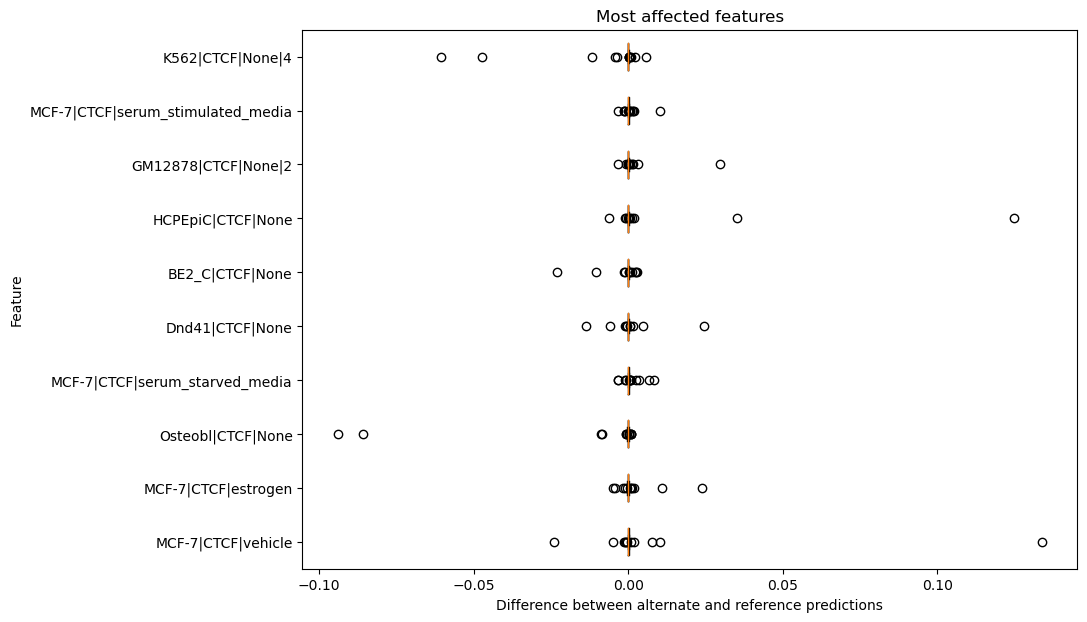

In [91]:
# Plot top 10 (CTCF)

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
ax.boxplot(deepsea_score_diff_ctcf_top, vert = 0)
ax.set_yticklabels(deepsea_score_diff_ctcf_top.columns)
plt.title('Most affected features')
plt.xlabel('Difference between alternate and reference predictions')
plt.ylabel('Feature')
plt.show()

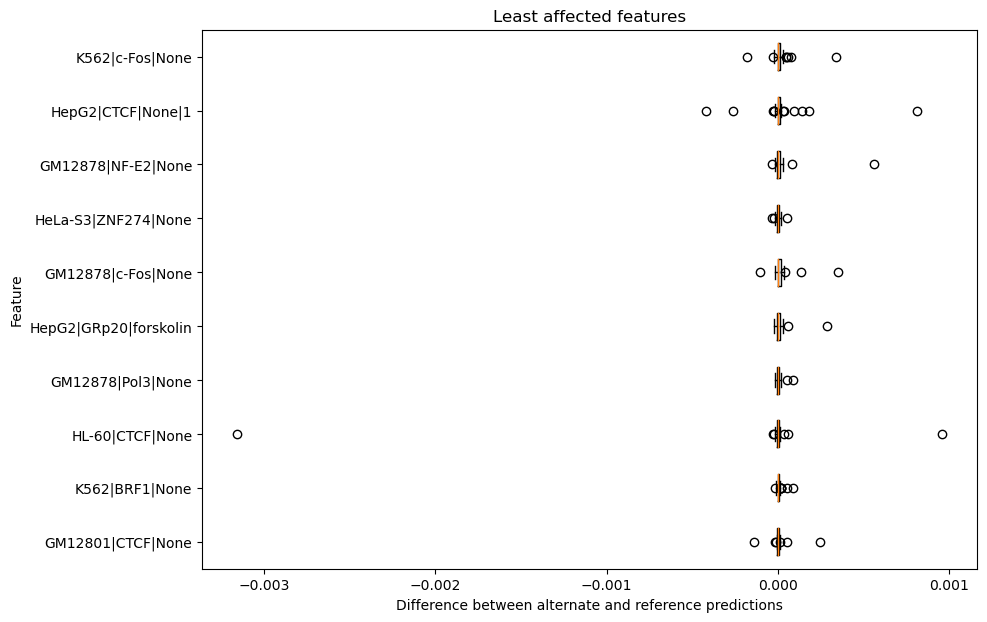

In [95]:
# Plot bottom 10

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
ax.boxplot(deepsea_score_diff_bottom, vert = 0)
ax.set_yticklabels(deepsea_score_diff_bottom.columns)
plt.title('Least affected features')
plt.xlabel('Difference between alternate and reference predictions')
plt.ylabel('Feature')
plt.show()